In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings("ignore")

In [2]:

IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/wildfire-detection-image-data/forest_fire/Training and Validation",
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
)
    

Found 1832 files belonging to 2 classes.


2022-10-06 15:57:54.733014: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/wildfire-detection-image-data/forest_fire/Testing",
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
)

Found 68 files belonging to 2 classes.


In [5]:
#our classes i.e. 2 different tomato leaf diseases
class_names = dataset.class_names
class_names

['fire', 'nofire']

2022-10-06 15:57:55.077669: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


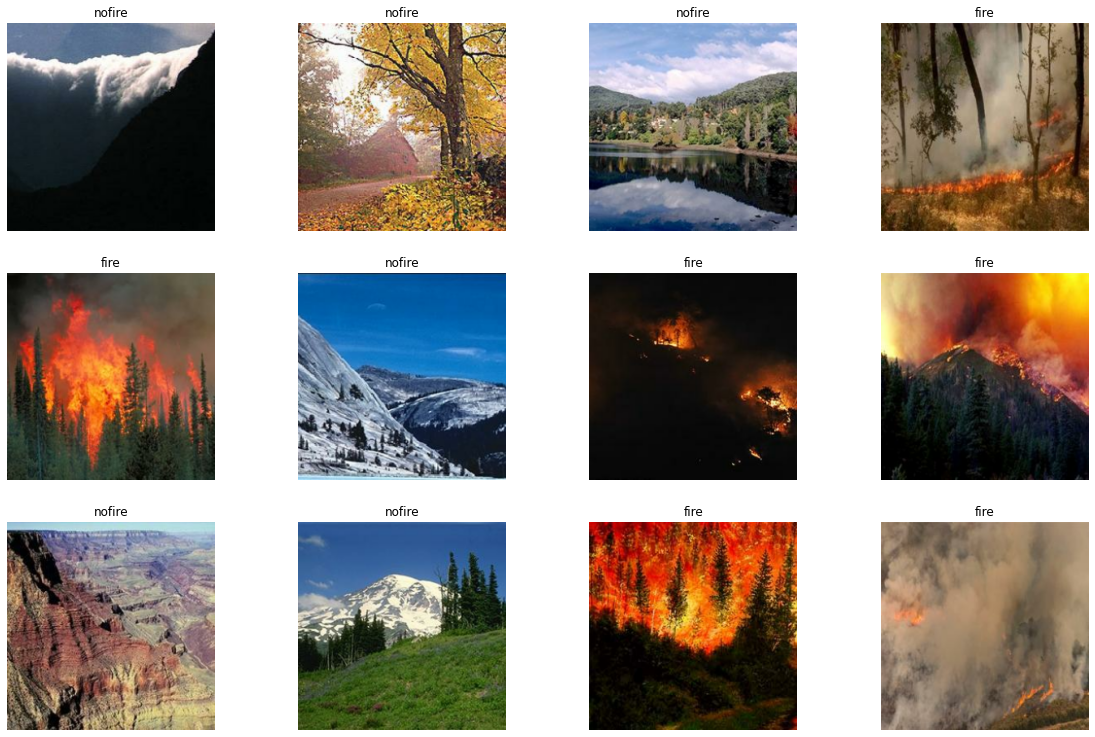

In [6]:
plt.figure(figsize=(20,13))

for image_batch, label_batch in dataset.take(1):
    
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

58

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.70, val_split=0.30,shuffle=True, shuffle_size=10000):
    assert (train_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    
    return train_ds, val_ds

In [9]:
train_ds, val_ds = get_dataset_partitions_tf(dataset)

In [10]:
len(train_ds)

40

In [11]:
len(val_ds)

17

In [12]:
#cache and prefetch to improve perfomance and reduce training time

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
#we resize the images to be of size 256 by 256
#then, we normalize the features by dividing it by 255

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [14]:
#augment the data to generate more data from a single picture e.g. same feature(image) when twisted horizontally or vertically
#when the feature(image) is rotated at some angle

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [15]:
# map training set to above data_augmentation to augment trainig set

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
#shape of input features

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 30, 30, 64)         

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
    
)

Epoch 1/50
40/40 [==============================] - 82s 2s/step - loss: 0.8224 - accuracy: 0.6592 - val_loss: 0.3255 - val_accuracy: 0.8798
Epoch 2/50
40/40 [==============================] - 78s 2s/step - loss: 0.2911 - accuracy: 0.8973 - val_loss: 0.1911 - val_accuracy: 0.9220
Epoch 3/50
40/40 [==============================] - 77s 2s/step - loss: 0.1985 - accuracy: 0.9236 - val_loss: 0.1603 - val_accuracy: 0.9443
Epoch 4/50
40/40 [==============================] - 78s 2s/step - loss: 0.1616 - accuracy: 0.9459 - val_loss: 0.1984 - val_accuracy: 0.9315
Epoch 5/50
40/40 [==============================] - 75s 2s/step - loss: 0.1472 - accuracy: 0.9506 - val_loss: 0.1156 - val_accuracy: 0.9650
Epoch 6/50
40/40 [==============================] - 77s 2s/step - loss: 0.1303 - accuracy: 0.9570 - val_loss: 0.1630 - val_accuracy: 0.9482
Epoch 7/50
40/40 [==============================] - 79s 2s/step - loss: 0.1780 - accuracy: 0.9498 - val_loss: 0.1235 - val_accuracy: 0.9634
Epoch 8/50
40/40 [==

In [20]:
model.save('./model.h5')

In [21]:
scores = model.evaluate(test_ds)

3/3 [==============================] - 1s 227ms/step - loss: 0.2385 - accuracy: 0.8971


In [22]:
scores

[0.23848864436149597, 0.8970588445663452]

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

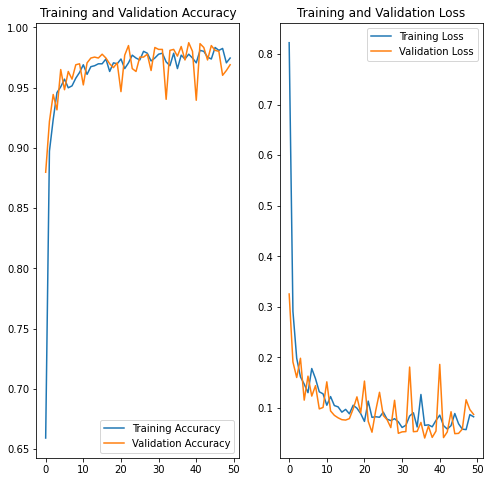

In [24]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()